In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
os.getcwd()

'/home/becode/dr-robin/concrete'

In [5]:
PATH = os.path.join(os.path.dirname('/home/becode/dr-robin/concrete/subset/'), 'W')
PATH = os.path.join(os.path.dirname('/home/becode/dr-robin/concrete/SDNET2018/'), 'W')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 18138 files belonging to 2 classes.


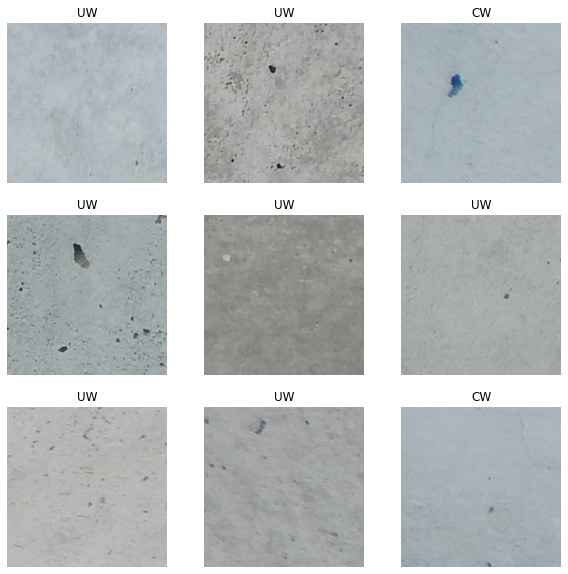

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
#Move 20% of data to validation set
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

In [8]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 454
Number of validation batches: 113


In [9]:
#Create test data set
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 4)
validation_dataset = validation_dataset.skip(validation_batches // 3)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 76
Number of test batches: 28


In [11]:
#Set buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
#Apply data augmentation, including rotation and horizontal flipping to reduce overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

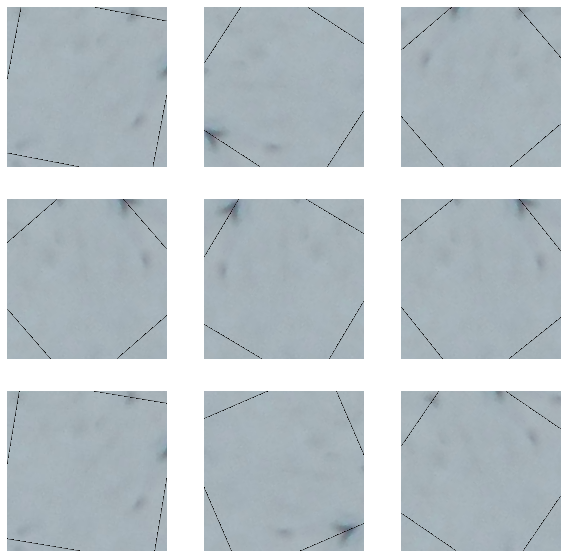

In [13]:
#Check the images after applying data augmentation
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [14]:
#rescale pixel values to [-1,1] or [0,1] based on base model
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [14]:
#Alternatively, you could rescale pixel values from [0,255] to [-1, 1] using a Rescaling layer.
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
# Create the base model from the pre-trained model InceptionV3, excludes the final classification layer, uses the bottleneck layer
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
#converts images into block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [17]:
#freeze the convulational base, prevents weights from updating during training
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
#Add classification layer for concrete images to convert features to image vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [20]:
#Add dense layer to convert features into prediction for image
#returns logit value, +ve is class 1, -ve is class 2
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [21]:
#Build model by chaining layers, data augmentation, rescaling/processing, base_model and feature extractor
#with training=False to avoid retraining earlier layers.
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
#Compile model and specify loss function
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

The 22M parameters in InceptionNet are frozen, but there are 2K _trainable_ parameters in the Dense layer.

In [24]:
len(model.trainable_variables)

2

In [53]:
#Train themodel
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

76/76 [==============================] - 69s 902ms/step - loss: 0.9102 - accuracy: 0.2208


In [54]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.22


In [27]:
#define callbacks to stop training if loss does not improve over 2 consecutive epoches
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1, restore_best_weights=False),
    tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=None)
]

In [28]:
#Start training model
initial_epochs = 50

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=my_callbacks)

Epoch 1/50
454/454 [==============================] - 569s 1s/step - loss: 0.5464 - accuracy: 0.7394 - val_loss: 0.5312 - val_accuracy: 0.6406
Epoch 2/50
454/454 [==============================] - 566s 1s/step - loss: 0.5105 - accuracy: 0.7584 - val_loss: 0.5236 - val_accuracy: 0.6024
Epoch 3/50
454/454 [==============================] - 563s 1s/step - loss: 0.4824 - accuracy: 0.7820 - val_loss: 0.5369 - val_accuracy: 0.5625
Epoch 4/50
454/454 [==============================] - 551s 1s/step - loss: 0.4698 - accuracy: 0.7856 - val_loss: 0.5162 - val_accuracy: 0.5938
Epoch 5/50
454/454 [==============================] - 541s 1s/step - loss: 0.4632 - accuracy: 0.7918 - val_loss: 0.4911 - val_accuracy: 0.6542
Epoch 6/50
454/454 [==============================] - 556s 1s/step - loss: 0.4577 - accuracy: 0.7940 - val_loss: 0.4886 - val_accuracy: 0.6501
Epoch 7/50
454/454 [==============================] - 558s 1s/step - loss: 0.4484 - accuracy: 0.8003 - val_loss: 0.4896 - val_accuracy: 0.6497

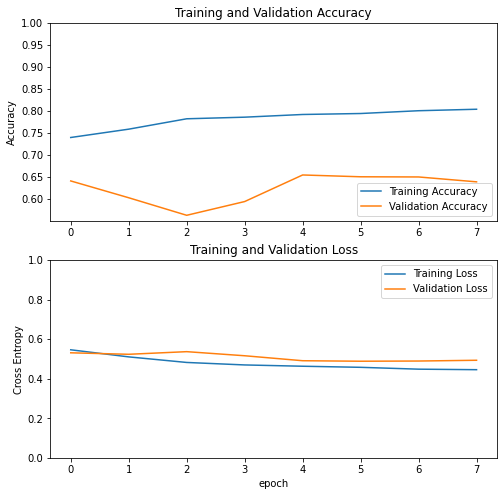

In [29]:
#Check learning curves after feature extraction using Inception V2 base model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


In [30]:
#Unfreeze
base_model.trainable = True

In [31]:
#how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  311


In [32]:
#compile model again - ready for fine-tuning final layers
#set lower learning rate to protect against overfitting
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [34]:
len(model.trainable_variables)

130

In [36]:
#continue training to fine-tune model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_finetuned.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1, restore_best_weights=False),
    tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', profile_batch=2, embeddings_freq=0,
    embeddings_metadata=None)
]

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks=my_callbacks)

Epoch 8/60
454/454 [==============================] - 1456s 3s/step - loss: 0.3754 - accuracy: 0.8424 - val_loss: 0.3091 - val_accuracy: 0.8816
Epoch 9/60
454/454 [==============================] - 1316s 3s/step - loss: 0.3229 - accuracy: 0.8721 - val_loss: 0.2924 - val_accuracy: 0.8943
Epoch 10/60
454/454 [==============================] - 1352s 3s/step - loss: 0.3084 - accuracy: 0.8811 - val_loss: 0.3232 - val_accuracy: 0.8914
Epoch 11/60
454/454 [==============================] - 1471s 3s/step - loss: 0.2916 - accuracy: 0.8885 - val_loss: 0.3457 - val_accuracy: 0.8882


In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

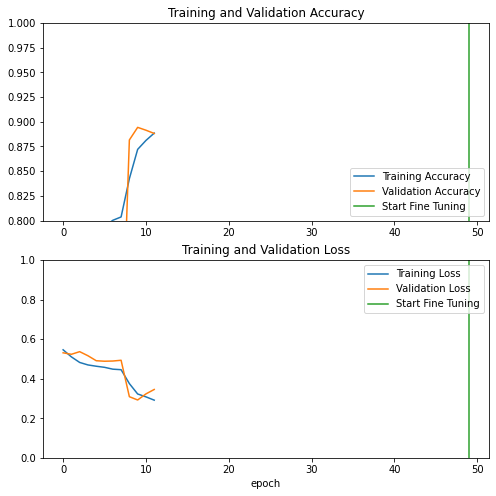

In [38]:
#Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
#evaluate performance on test dataset
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

28/28 [==============================] - 21s 745ms/step - loss: 0.3581 - accuracy: 0.9085
Test accuracy : 0.9084821343421936


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Labels:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1]


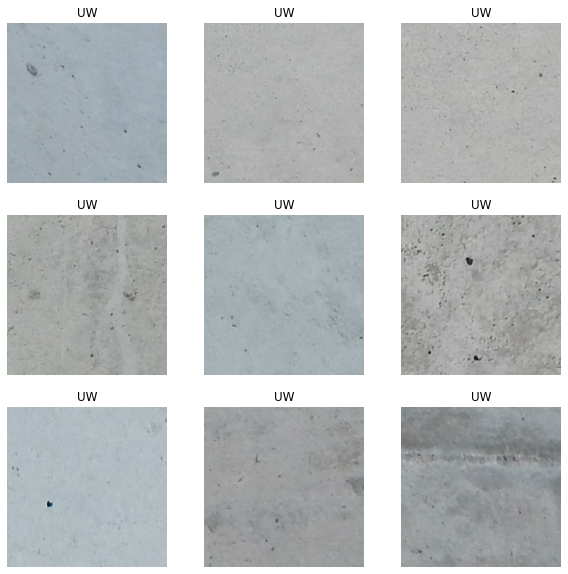

In [40]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [44]:
class_names[predictions[0]]

'UW'

In [48]:
class_names[predictions[30]]

'CW'

In [59]:
predictions = model.predict_on_batch(image_batch).flatten()

In [3]:
predictions

NameError: name 'predictions' is not defined

In [1]:
plt.imshow(image_batch[30].astype("uint8"))
print(predictions[30])

NameError: name 'plt' is not defined

In [53]:
dir(predictions[30])

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',


In [4]:
#Convert tensorflow model to tensorflow lite model
import tensorflow as tf
model = tf.keras.models.load_model('model_finetuned.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model_finetuned.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp8_8lz10w/assets


87142452